# PANTER JET-X Ray Trace
## Alexandra Higley 

Here I will be ray tracing the tweleve shells of the JET-X optic at the PANTER x-ray tets facility, as well as the grating Jake is making for the PANTER trip in October-November 2023.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
import sys
import pdb
from copy import deepcopy
from tqdm import tqdm
import astropy.units as u
import mpl_scatter_density

import seaborn as sns
plt.style.use('seaborn')

/var/folders/d7/mj7t5gvn7kxcpnv91gn5rxs5myk4z8/T/ipykernel_91953/2184438354.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
sys.path.append('/Users/anh5866/Desktop/Coding')
import PyXFocus.sources as sources
import PyXFocus.transformations as trans
import PyXFocus.surfaces as surfaces
import PyXFocus.analyses as analyses
import PyXFocus.conicsolve as conic

import OGRE.ogre_routines_alexplay as ogre

soxs : [WARNING  ] 2025-03-03 17:12:10,401 Setting 'soxs_data_dir' to /Users/anh5866/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


Below I define some of the parameters for JET-X, such as the the focal length and the radii of the shells at the intersection node. Note that I _think_ that the parabolic and hyperbolic mirrors are not seperated, but instead flow right into each other. Due to this, the mirror seperation will be zero. 

Other parameters added is the length of the mirrors. Both the parabolic and hyperbolic mirrors have a length of 300 mm, and the length of the PANTER chamber. We also choose which source we want and specify the wavelength. 

In [3]:
# Define JET-X optic parameters.
z0 = 3500. * u.mm  # Focal length.

d_int = np.array([187.181697, 195.044289, 203.186973, 211.689775, 220.552696, 229.775737, 239.398908, 249.422212, 
                  259.865654, 270.729235, 282.052968, 293.856858]) * u.mm  # Diameter at intersection node.

r_int = d_int/2 #Radius at intersection node


mirror_length = 300 * u.mm  # Axial length of primary / secondary mirror.
mirror_sep = 0 * u.mm  # Separation between primary and secondary mirrors.


# PANTER Parameters
L = (123000. + 12000) * u.mm  # Approximate.
L -= 4000. * u.mm  # Accounts for focal length of optic in the finite conjugate.
#L = 10e12 * u.mm

#wave = 0.98903  # [nm] Mg-K wavelength.
wave = 0.83401 * u.nm # Al-K wavelength.

print(r_int)

print(L)

[ 93.5908485  97.5221445 101.5934865 105.8448875 110.276348  114.8878685
 119.699454  124.711106  129.932827  135.3646175 141.026484  146.928429 ] mm
131000.0 mm


### Optic Simulation 

Next we will simulate the optic. Using the radii of the tweleve shells of JET-X, we will find the **Pick Up Here**

In [4]:
# Define inner and outer subannulus radii.
z_in = z0 + mirror_sep/2
z_out = z_in + mirror_length

print(z_in)
print(z_out)

r_in = conic.primrad(z_in, r_int[0], z0)
r_out = conic.primrad(z_out, r_int[-1], z0) #-1 is the last value in array 

print(r_in)
print(r_out)

3500.0 mm
3800.0 mm
93.5908484999825 mm
150.04216963869828 mm


In [5]:
# Define full angular width of subannulus.
dphi = 30 * u.deg
#dphi = 360 * u.deg

```
def subannulus(rin, rout, dphi, num, zhat=1.):
    '''
    Subapertured annulus source with specified inner and outer
    radii, as well as angular extent.

    Note: Annulus is centered about theta = 0, which points
          in the +x direction.

    Parameters
    ----------
    rin : int / float
        Inner radius of annulus.
    rout : int / float
        Outer radius of annulus.
    dphi : int / float
        Full angular width of subannulus.
    num : int
        Number of rays to create.
    zhat : float
        Direction in which rays point. Default is zhat = +1.

    Returns
    -------
    rays : list
        List of ray parameters [opd, x, y, z, l, m, n, ux, uy, uz].
    '''
````

<br>

Functions in this module create rays emenating from a variety of sources in the form [opd, x, y, z, l, m, n, ux, uy, uz].

Ray Parameters:
- opd : vector tracking the optical path traveled by each ray; only surfaces with an OPD flag in their definition will update this vector.
- x, y, z : ray positions in the Cartesian coordinate system [mm].
- l, m, n : ray direction cosines, indicating the direction in which each ray is moving; magnitude is unity.
- ux, uy, uz : the surface normal of the last surface to which the ray was traced; magnitude is unity.
<br>
<br>

In [6]:
# Define subannulus of rays.
rays = sources.subannulus(r_in.to('mm').value, r_out.to('mm').value,
                          dphi.to('rad').value, 100000)

Need to move it into from configuration in the x-direction. If you instead rotated by pi/2 rather than -pi/2 you would be in smile configuration. Note that we are at z=zero, which is at the very "front" of the spectrometer, that is, detector-side. This is where the focus is defined to be, 3500mm away from the intersection of the mirrors. The intersection is at z=3500mm right now. 

In [7]:
# Rotate so that dispersion direction is in the x-dimension.
trans.transform(rays, 0, 0, 0, 0, 0, -np.pi/2)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 30.32882918,  -7.43627897,  24.87290211, ..., -10.92342794,
         -4.14566724,   1.20529818]),
 array([128.27751303, 102.42450679, 142.48645609, ..., 118.0904513 ,
        144.75231075, 124.27150985]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

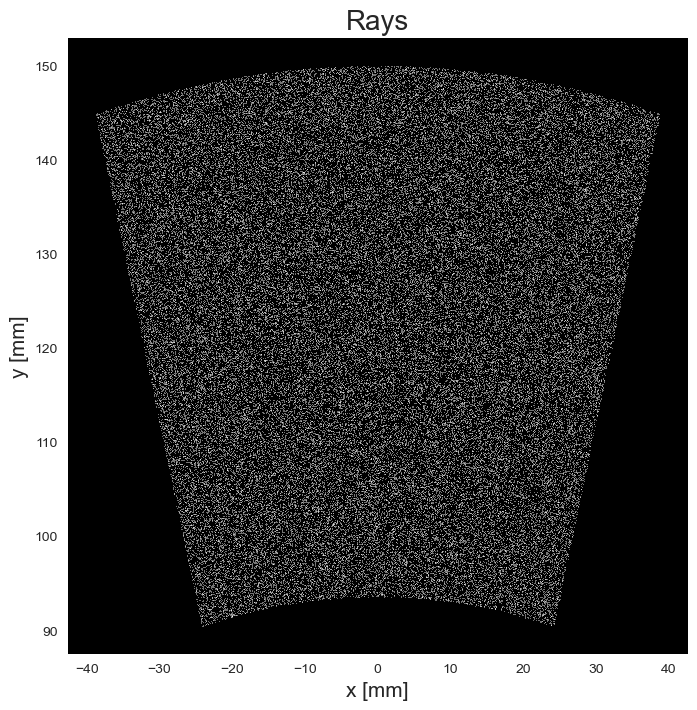

In [8]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


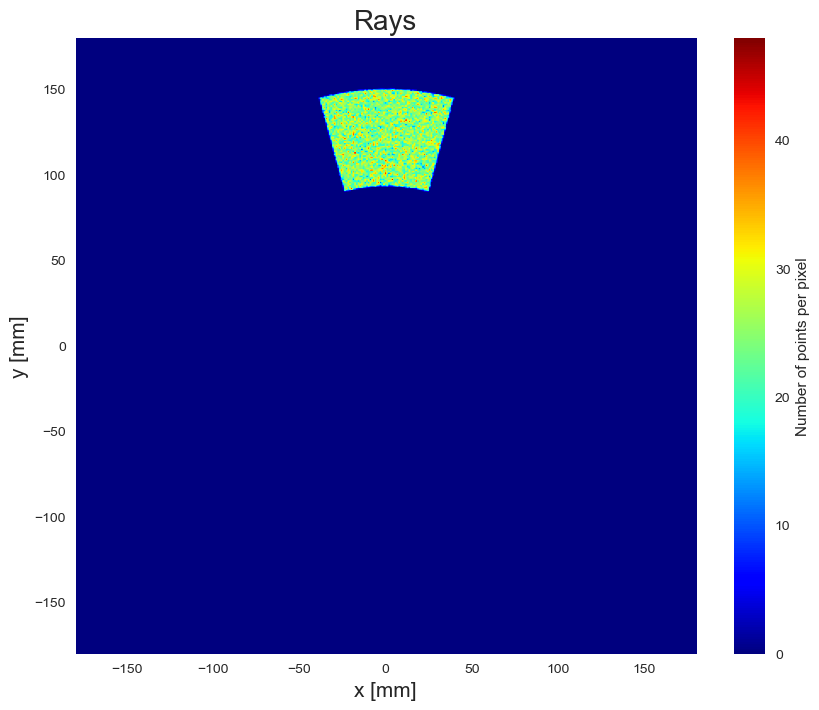

In [9]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
ax1.set_ylim(-180,180)
ax1.set_xlim(-180,180)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

ax1.set_title("Rays", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

Since the source is not starting from somewhere infinitely far away, we need to manually add dispersion using the length of PANTER. First, we find the center of the beam and move to the center of the beam in the y-direction (move down to center and define that as zero)

For a dphi of 360 degrees, this should not move the rays much in the y-direction. 

In [10]:
# Find centroid of rays and move rays down to center of beamline.
cen_optic = analyses.centroid(rays)
trans.transform(rays, 0, cen_optic[1], 0, 0, 0, 0)

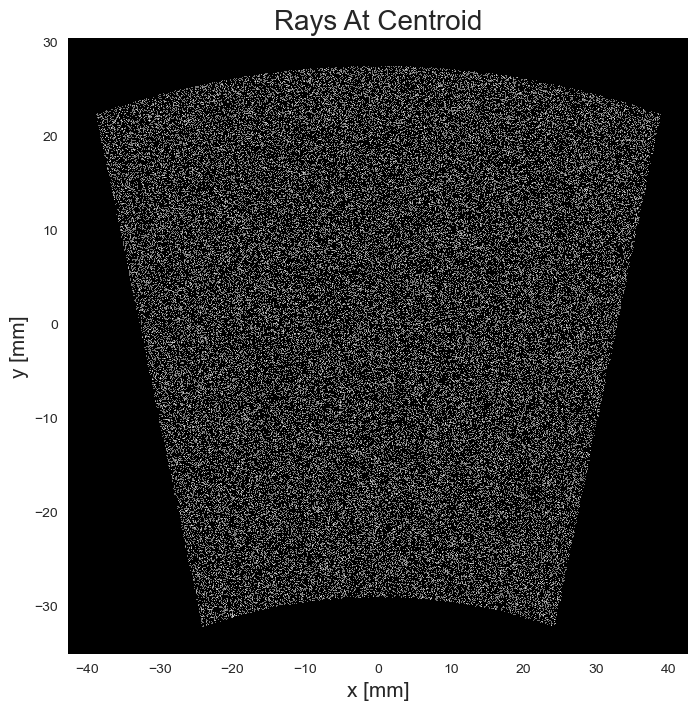

In [11]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

In [12]:
# Change ray direction cosines to emanate from source (48 m away). Long cell
# Change ray direction cosines to emanate from source (131 m away). PANTER
hyp = np.sqrt(L.to('mm').value**2 + rays[1]**2 + rays[2]**2)
l = rays[1]/hyp
m = rays[2]/hyp
n = -np.sqrt(1. - l**2 - m**2)
rays = [rays[0], rays[1], rays[2], rays[3],
        l, m, n, rays[7], rays[8], rays[9]]

Now that the beam has direction cosines, we need to return back to where we were originally by moving back up and out of the center (y-direction) ie, we are returning to original coordinate system.  

Then you need to move everything to the intersection node. 

In [13]:
# Shift rays back up.
trans.transform(rays, 0, -cen_optic[1], 0, 0, 0, 0)

# move global orgin to JET-X focus
trans.transform(rays, 0, 0, -z0.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 30.32882918,  -7.43627897,  24.87290211, ..., -10.92342794,
         -4.14566724,   1.20529818]),
 array([128.27751303, 102.42450679, 142.48645609, ..., 118.0904513 ,
        144.75231075, 124.27150985]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([ 2.31517774e-04, -5.67654876e-05,  1.89869476e-04, ...,
        -8.33849457e-05, -3.16463144e-05,  9.20074945e-06]),
 array([ 4.34839412e-05, -1.53867248e-04,  1.51949152e-04, ...,
        -3.42798874e-05,  1.69245755e-04,  1.29037655e-05]),
 array([-0.99999997, -0.99999999, -0.99999997, ..., -1.        ,
        -0.99999999, -1.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

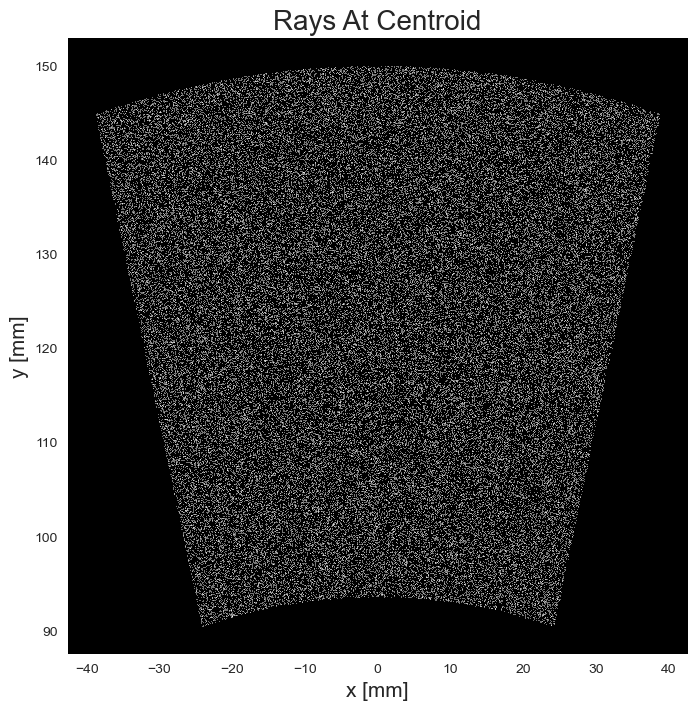

In [14]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

Now that all the rays are at the intersection node and in frown configuration (if dphi does not equal 360 degrees), we need to pass them through the mirrors. Here, we have twelve mirror shells. I first define an empty "new_ray" object, where we will append the rays after they pass through the mirrors.

Then, we find the front and back radii of of all three shells using conic.primrad. Recall that it looks like this for one shell:

```
r_in = conic.primrad(z_in, r_int, z0)
r_out = conic.primrad(z_out, r_int, z0)
```

When applying conic.primrad here, cycles through all twelve values in zp_front/ zp_back, and all twelve values in r_int ("r" here is like "i"). I am pretty sure this specific technique is called _"list comprehension"_ — i just avoid lists a lot so that is why I don't understand it very well. Seems convenient though. 

In [15]:
# Define blank PyXFocus ray object.
new_rays = sources.annulus(0,0,0) 

# Define mirror parameters.
zp_back = z0 + mirror_sep/2  # Axial position of parabola front.
zp_front = zp_back + mirror_length  # axial position of parabola back.

rp_front = [conic.primrad(zp_front, r, z0) for r in r_int]
rp_back = [conic.primrad(zp_back, r, z0) for r in r_int]

#applies conic.primrad to 

print(rp_front)
print(rp_back)

print(r_in)
print(r_out)

print(r_int)

[<Quantity 95.57488881 mm>, <Quantity 99.5894855 mm>, <Quantity 103.74709054 mm>, <Quantity 108.08856388 mm>, <Quantity 112.61390502 mm>, <Quantity 117.32311337 mm>, <Quantity 122.23661642 mm>, <Quantity 127.35441427 mm>, <Quantity 132.68671967 mm>, <Quantity 138.23353132 mm>, <Quantity 144.01527733 mm>, <Quantity 150.04216964 mm>]
[<Quantity 93.5908485 mm>, <Quantity 97.5221445 mm>, <Quantity 101.5934865 mm>, <Quantity 105.8448875 mm>, <Quantity 110.276348 mm>, <Quantity 114.8878685 mm>, <Quantity 119.699454 mm>, <Quantity 124.711106 mm>, <Quantity 129.932827 mm>, <Quantity 135.3646175 mm>, <Quantity 141.026484 mm>, <Quantity 146.928429 mm>]
93.5908484999825 mm
150.04216963869828 mm
[ 93.5908485  97.5221445 101.5934865 105.8448875 110.276348  114.8878685
 119.699454  124.711106  129.932827  135.3646175 141.026484  146.928429 ] mm


In [16]:
print(len(rays[1]))

100000


In [17]:
def loc_rays(rays, rp_back, rp_front):
    
    # Find photons which will hit this mirror shell.
    r = np.sqrt(rays[1]**2 + rays[2]**2) #cartesian to polar transformation — "r" as radius for each of the rays
    # r = sqrt(x^2 + y^2)

    #this need to be edited. Another function perhaps ?
    ind = np.where((r > rp_back.to('mm').value) & (r < rp_front.to('mm').value))[0]
    #which rays fall within each shell (from each persspecive front radii to back radii)
    
    # Create new ray object with only these rays.
    ind_rays = [r[ind] for r in rays] #mask
    
    return ind_rays

In [18]:
#index/ fix this 

som1 = loc_rays(rays, rp_back[0], rp_front[0])
som2 = loc_rays(rays, rp_back[1], rp_front[1])
som3 = loc_rays(rays, rp_back[2], rp_front[2])
som4 = loc_rays(rays, rp_back[3], rp_front[3])
som5 = loc_rays(rays, rp_back[4], rp_front[4])
som6 = loc_rays(rays, rp_back[5], rp_front[5])
som7 = loc_rays(rays, rp_back[6], rp_front[6])
som8 = loc_rays(rays, rp_back[7], rp_front[7])
som9 = loc_rays(rays, rp_back[8], rp_front[8])
som10 = loc_rays(rays, rp_back[9], rp_front[9])
som11 = loc_rays(rays, rp_back[10], rp_front[10])
som12 = loc_rays(rays, rp_back[11], rp_front[11])

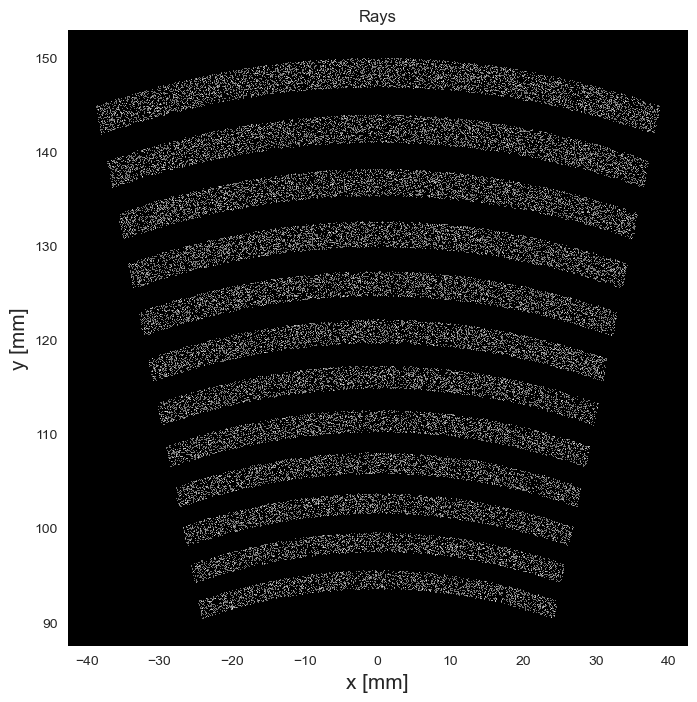

In [19]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()


In [20]:
print(len(rays[1]))
print(len(som1[0]))


#plt y/x

100000
2735


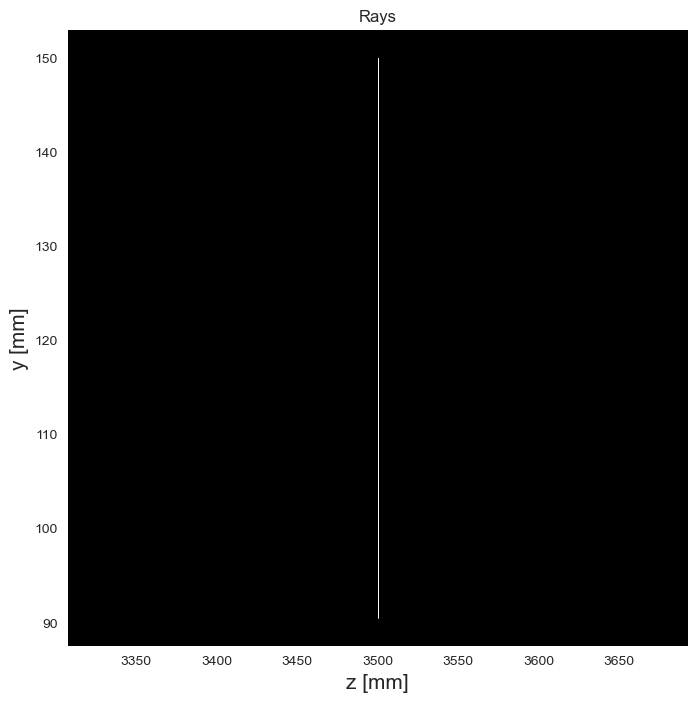

In [21]:
#x - z projection, selecting pieces. Note that it is at 3500 
#(where the intersection node is placed in the coordinate system relative to zero (the source_))



with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('z [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[3], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[3], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[3], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[3], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[3], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[3], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[3], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[3], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[3], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[3], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[3], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[3], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [22]:
def loc_primary(rays, r_int):
    # Propagate these photons to primary mirror.
    surfaces.wolterprimary(rays, r_int.to('mm').value, z0.to('mm').value)
    
    # Find which photons interact with this mirror.
    ind = np.where((rays[3] > (z0 + mirror_sep/2).to('mm').value) &
                   (rays[3] < (z0 + mirror_sep/2 + mirror_length).to('mm').value))[0]

    # Keep only the photons which interact with the actual size
    # of the mirror
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays

In [23]:
som1 = loc_primary(som1, r_int[0])
som2 = loc_primary(som2, r_int[1])
som3 = loc_primary(som3, r_int[2])
som4 = loc_primary(som4, r_int[3])
som5 = loc_primary(som5, r_int[4])
som6 = loc_primary(som6, r_int[5])
som7 = loc_primary(som7, r_int[6])
som8 = loc_primary(som8, r_int[7])
som9 = loc_primary(som9, r_int[8])
som10 = loc_primary(som10, r_int[9])
som11 = loc_primary(som11, r_int[10])
som12 = loc_primary(som12, r_int[11])

In [24]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

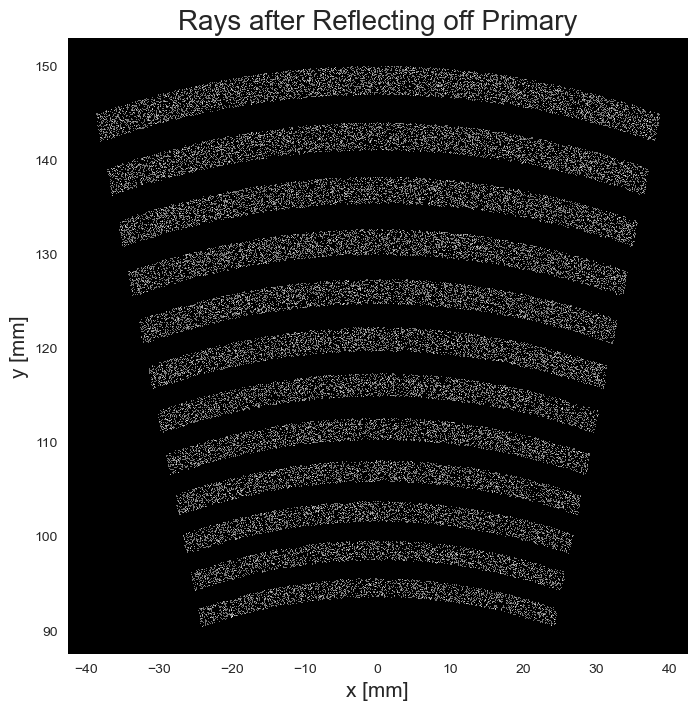

In [25]:
with sns.axes_style("ticks"):
    
   #matplotlib.rc('text',usetex=True)
   # matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Primary", fontsize=20)
    #ax1.grid()


In [26]:
def beck(num):
    ogre.beckmann_scatter(som1, 0, 0, num)
    ogre.beckmann_scatter(som2, 0, 0, num)
    ogre.beckmann_scatter(som3, 0, 0, num)
    ogre.beckmann_scatter(som4, 0, 0, num)
    ogre.beckmann_scatter(som5, 0, 0, num)
    ogre.beckmann_scatter(som6, 0, 0, num)
    ogre.beckmann_scatter(som7, 0, 0, num)
    ogre.beckmann_scatter(som8, 0, 0, num)
    ogre.beckmann_scatter(som9, 0, 0, num)
    ogre.beckmann_scatter(som10, 0, 0, num)
    ogre.beckmann_scatter(som11, 0, 0, num)
    ogre.beckmann_scatter(som12, 0, 0, num)
    
    return
    
beck(1.96e-4) 
# used to be 1.48e-5

In [27]:
def loc_secondary(rays, r_int):
    
    # Propagate photons to the secondary mirror.
    surfaces.woltersecondary(rays, r_int.to('mm').value, z0.to('mm').value)

    # Find which photons will interact with hyperboloid.
    ind = np.where((rays[3] < (z0 - mirror_sep/2).to('mm').value) &
                   (rays[3] > (z0 - mirror_sep/2 - mirror_length).to('mm').value))[0]
    
    # keep only photons which interact with mirror.
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays           

In [28]:
som1 = loc_secondary(som1, r_int[0])
som2 = loc_secondary(som2, r_int[1])
som3 = loc_secondary(som3, r_int[2])
som4 = loc_secondary(som4, r_int[3])
som5 = loc_secondary(som5, r_int[4])
som6 = loc_secondary(som6, r_int[5])
som7 = loc_secondary(som7, r_int[6])
som8 = loc_secondary(som8, r_int[7])
som9 = loc_secondary(som9, r_int[8])
som10 = loc_secondary(som10, r_int[9])
som11 = loc_secondary(som11, r_int[10])
som12 = loc_secondary(som12, r_int[11])

In [29]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

In [30]:
def gauss(num):
    
    som1[5] += np.random.normal(scale=num, size=len(som1[5]))
    som2[5] += np.random.normal(scale=num, size=len(som2[5]))
    som3[5] += np.random.normal(scale=num, size=len(som3[5]))
    som4[5] += np.random.normal(scale=num, size=len(som4[5]))
    som5[5] += np.random.normal(scale=num, size=len(som5[5]))
    som6[5] += np.random.normal(scale=num, size=len(som6[5]))
    som7[5] += np.random.normal(scale=num, size=len(som7[5]))
    som8[5] += np.random.normal(scale=num, size=len(som8[5]))
    som9[5] += np.random.normal(scale=num, size=len(som9[5]))
    som10[5] += np.random.normal(scale=num, size=len(som10[5]))
    som11[5] += np.random.normal(scale=num, size=len(som11[5]))
    som12[5] += np.random.normal(scale=num, size=len(som12[5]))


    som1[6] = -np.sqrt(1. - som1[5]**2 - som1[4]**2)
    som2[6] = -np.sqrt(1. - som2[5]**2 - som2[4]**2)
    som3[6] = -np.sqrt(1. - som3[5]**2 - som3[4]**2)
    som4[6] = -np.sqrt(1. - som4[5]**2 - som4[4]**2)
    som5[6] = -np.sqrt(1. - som5[5]**2 - som5[4]**2)
    som6[6] = -np.sqrt(1. - som6[5]**2 - som6[4]**2)
    som7[6] = -np.sqrt(1. - som7[5]**2 - som7[4]**2)
    som8[6] = -np.sqrt(1. - som8[5]**2 - som8[4]**2)
    som9[6] = -np.sqrt(1. - som9[5]**2 - som9[4]**2)
    som10[6] = -np.sqrt(1. - som10[5]**2 - som10[4]**2)
    som11[6] = -np.sqrt(1. - som11[5]**2 - som11[4]**2)
    som12[6] = -np.sqrt(1. - som12[5]**2 - som12[4]**2)

#gauss(7e-6)
#originally 1.2e-5

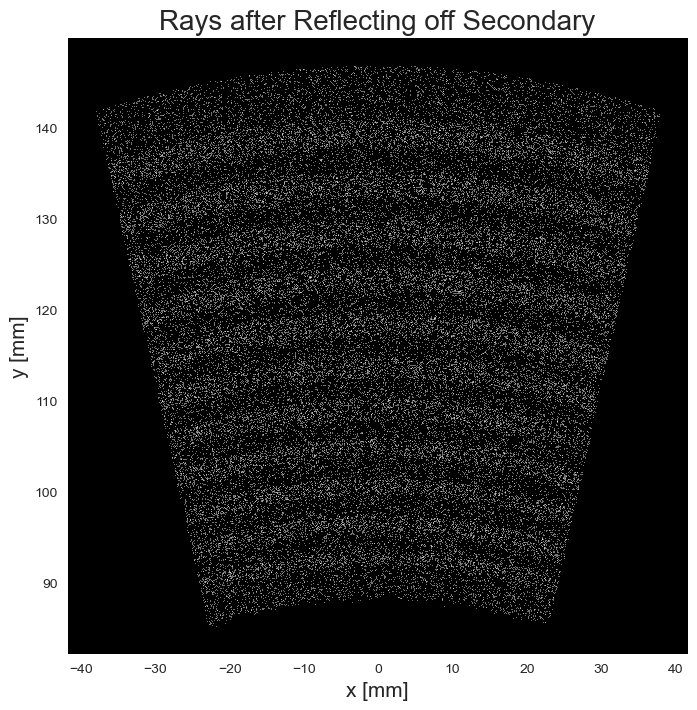

In [31]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Secondary", fontsize=20)
    #ax1.grid()

In [32]:
# Add to 'master' PyXFocus ray object.
new_rays = [np.append(new_rays[i], som1[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som2[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som3[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som4[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som5[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som6[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som7[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som8[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som9[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som10[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som11[i])
            for i in range(len(new_rays))]

new_rays = [np.append(new_rays[i], som12[i])
            for i in range(len(new_rays))]

print(len(new_rays[0]))

53237


In [33]:
rays = trans.copy_rays(new_rays)

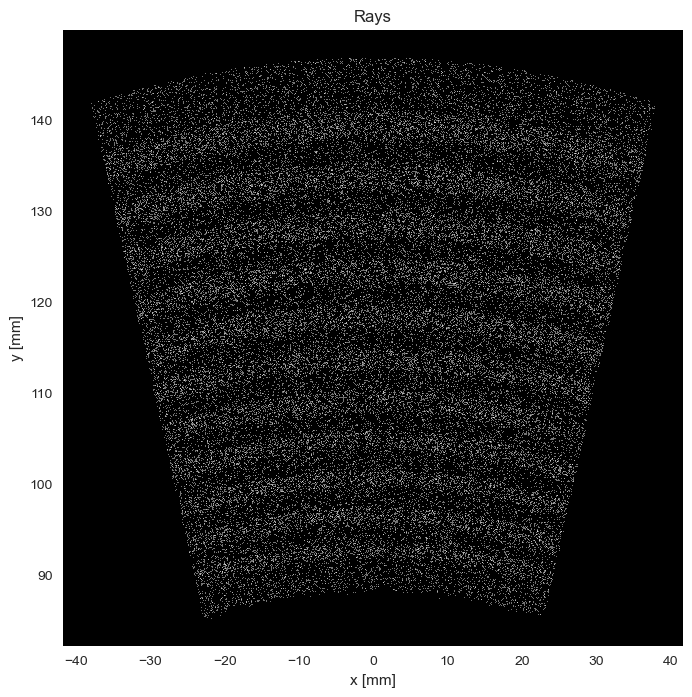

In [34]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [35]:
# Go to the X-ray focus.
f0 = surfaces.focusX(rays) #put z to focus 

print(f0)

#theoretically you can use thin lens equation for sanity check 
# also matches up with PANTER observed

-96.06276558058926


In [36]:
# Put optic focus at y=0.


#find mean of y -- finite source so the path length for the rays are different from one another, 
#will be shifted downwards by some amount. 


# each source has different focal length ; each has different magnification 

# ratios between size of image and sie of extra focual image with distance object/ distance sourse is same,
# sanity check; picture 05/27

cen_y = np.mean(rays[2])
print(cen_y)
trans.transform(rays, 0, cen_y, 0, 0, 0, 0)

# Copy rays to reference later.
of_rays = deepcopy(rays)

rays

-3.364530169857414


[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00152442,  0.02513511, -0.01086674, ..., -0.10687386,
        -0.02953038, -0.00022365]),
 array([ 0.03652557,  0.10078825,  0.08007149, ...,  1.08498715,
        -0.11570294, -0.49032428]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00121869, -0.00550762,  0.00398927, ...,  0.00411534,
        -0.01007425, -0.00034363]),
 array([-0.0274235 , -0.02677237, -0.0271347 , ..., -0.04184594,
        -0.04107987, -0.04263367]),
 array([-0.99962316, -0.99962638, -0.99962383, ..., -0.9991156 ,
        -0.99910508, -0.99909071]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

Optic FWHM (Disp. Dir.): 9.99790983663869 arcsec
Optic HPD (X-Disp. Dir.): 28.20230954422017 arcsec


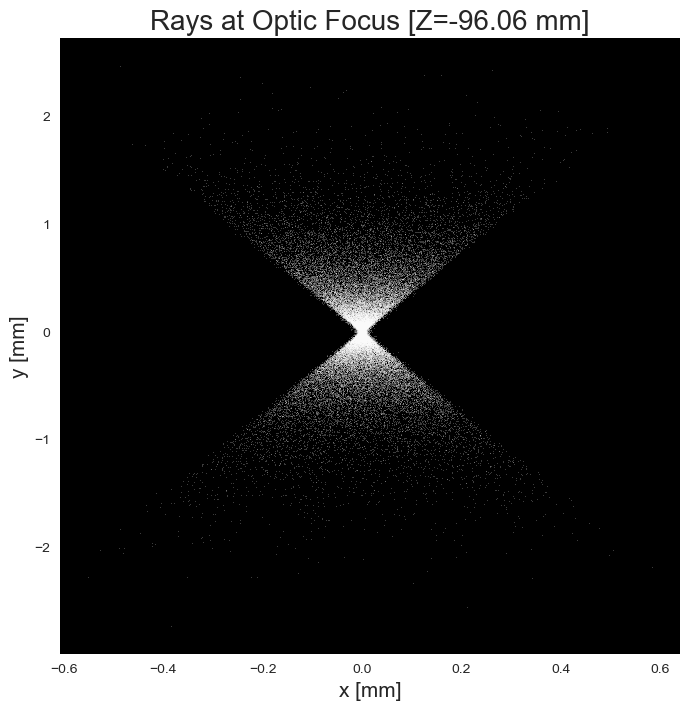

In [37]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.3, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays at Optic Focus [Z=" + str(round(f0, 2)) + " mm]", fontsize=20)
    #ax1.grid()
    
fwhm_disp = np.std(rays[1]) * 2.355 / (z0.value - f0) * 206265 * u.arcsec
hpd_xdisp = analyses.hpdY(rays) / (z0.value - f0) * 206265 * u.arcsec
#plt.text(0.15, 0.2, 'Disp. FWHM = ' + str(round(fwhm_disp.value, 2)) + '"')
#plt.text(0.15, 0.15, 'X-Disp. HPD = ' + str(round(hpd_xdisp.value, 2)) + '"')

print('Optic FWHM (Disp. Dir.): ' + str(fwhm_disp))
print('Optic HPD (X-Disp. Dir.): ' + str(hpd_xdisp))


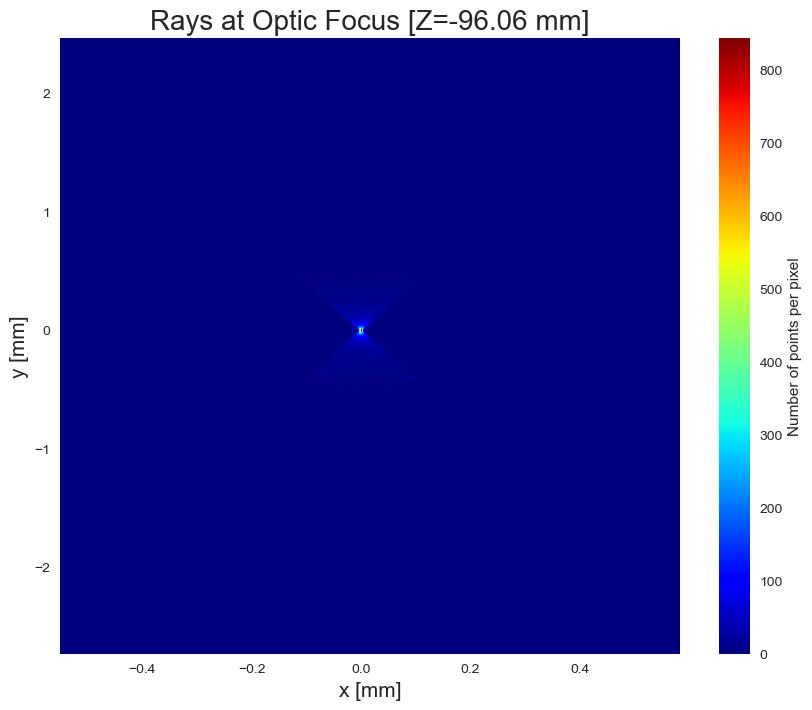

In [38]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
#color_map = plt.get_cmap('nipy_spectral')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
#density = ax1.scatter_density(rays[1], rays[2], cmap = color_map, vmin = 0, vmax = 20)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

ax1.set_title("Rays at Optic Focus [Z=" + str(round(f0, 2)) + " mm]", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

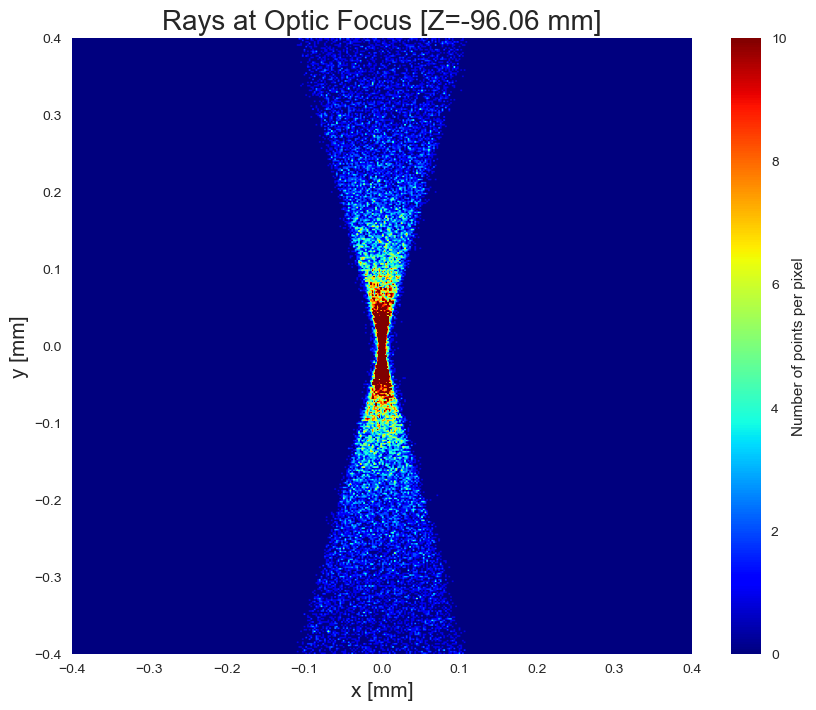

In [39]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

#density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
density = ax1.scatter_density(rays[1], rays[2], cmap = color_map, vmin = 0, vmax = 10)

ax1.set_ylim(-0.4,0.4)
ax1.set_xlim(-0.4,0.4)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

ax1.set_title("Rays at Optic Focus [Z=" + str(round(f0, 2)) + " mm]", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

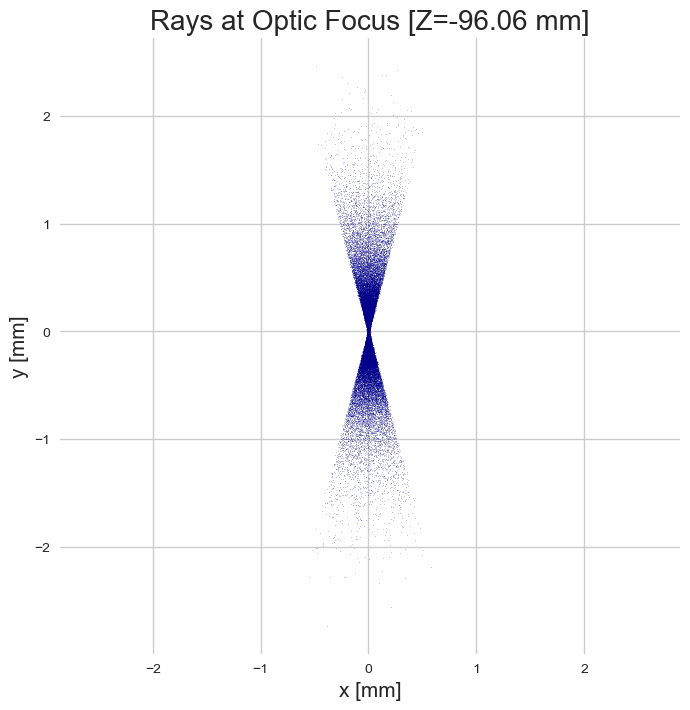

In [40]:
with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)

    ax1.set_title("Rays at Optic Focus [Z=" + str(round(f0, 2)) + " mm]", fontsize=20)

    ax1.scatter(rays[1], rays[2], color="darkblue", alpha=0.3, marker='.',  s=0.5)
    ax1.axis('equal')

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    #ax1.grid()


## Grating Simulation 

In [41]:
# Grating Parameters 
hub = 3000. * u.mm  # Hub length

# convergence length from center of grating 
d = 315.15 * u.nm # [nm] At 3300 mm from grating hub.
d *= 3000 * u.mm / hub # Redefine to value at center of grating.

gammy = 1.5 * u.deg  # Graze angle. #not gamma #eta
blaze = 0.575959 * u.rad  # Blaze angle. #33 degrees

yaw = 0.70 * u.deg  # Yaw of grating.
throw = hub / np.cos(gammy)

grat_length = 70. * u.mm
grat_width = 63 * u.mm

print(d)
#write grating equation anayltically 

315.15 nm


In [42]:
# mask ?
# spider? 

In [43]:
# Calculate mean convergence angle of rays.
# 4*alpha 

r = np.mean(r_int) - cen_y * u.mm
z = z0 - f0 * u.mm

conv_ang = np.arctan(r/z)
print('Optic Convergence Angle: ' + str(conv_ang))

Optic Convergence Angle: 0.03386097171857165 rad


In [44]:
# Find how far we need to move from focal plane.
z_grat = np.cos(abs(conv_ang)) * throw
r_grat = np.sin(abs(conv_ang)) * throw

print(z_grat)
print(r_grat)

2999.3081041895744 mm
101.59831956578792 mm


In [45]:
# Establish starting coordinates.
glob_coords = [trans.tr.identity_matrix()] * 4 #just how coords works when using transform 

#save point at the focus

print(glob_coords)

[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]


In [46]:
# Move to grating location.
trans.transform(rays, 0, r_grat.to('mm').value, z_grat.to('mm').value, 0, 0, 0, coords=glob_coords)

In [47]:
trans.transform(rays, 0, 0, 0, -np.pi/2, 0, 0, coords=glob_coords)
trans.transform(rays, 0, 0, 0, -conv_ang.to('rad').value, 0, 0, coords=glob_coords) #orthoganal to rays 
# The above puts +y pointed towards the focus.
#moer than 90 degrees 

# Put incidence angle onto grating.
trans.transform(rays, 0, 0, 0, gammy.to('rad').value, 0, 0, coords=glob_coords)

# Get +y to point towards grating surface for radgrat function.
trans.transform(rays, 0, 0, 0, 0, 0, np.pi, coords=glob_coords) # x going into page
#set up for radgrat 
#which way in x grooves open up in function 


# Add yaw.
#trans.transform(rays, 0, 0, 0, 0, 0, -yaw.to('rad').value, coords=glob_coords)

# Go to hub location.
trans.transform(rays, 0, -hub.to('mm').value, 0, 0, 0, 0, coords=glob_coords)
# Project photons onto x-y plane (the grating surface).
surfaces.flat(rays)

In [48]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([  4.84805993, -22.65646951,  16.10213317, ...,   9.43734756,
        -23.69704124,  -0.7767912 ]),
 array([3976.06337358, 4108.28506595, 4032.83929339, ..., 2265.9048389 ,
        2353.7353002 , 2259.81539511]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00121869,  0.00550762, -0.00398927, ..., -0.00411534,
         0.01007425,  0.00034363]),
 array([-0.99980431, -0.99980253, -0.99980276, ..., -0.99940754,
        -0.99939114, -0.99938871]),
 array([-0.01974462, -0.01909349, -0.01945583, ..., -0.03417054,
        -0.03340458, -0.03495844]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [49]:
# Ben's way of checking to see which rays have already been diffracted if you wanted to keep track of more than one
# order 

#Maybe a better way to do this is when you stick it all into a function, you have a way to specify the order every
# time called


diff_inds = np.array([])
waves = np.ones(len(rays[0])) * wave

ind = np.where((rays[2] > (hub - grat_length/2).to('mm').value) &
               (rays[2] < (hub + grat_length/2).to('mm').value))[0]
#this is a grating length 
#in y are the rays consistant with length of grating 
# rays that actually hit the grating 

'''
# Remove indices which have already been reflected/diffracted.
ind = ind[np.isin(ind, diff_inds, invert=True)]
ind = np.array(ind, dtype=int)
diff_inds = np.concatenate((ind, diff_inds))

for i in range(1):
# If there are no rays that interact with the grating, continue.
    if len(ind) < 1:
        rays = trans.applyT(rays, glob_coords, inverse=True)
    
        continue
# no i 


'''


'\n# Remove indices which have already been reflected/diffracted.\nind = ind[np.isin(ind, diff_inds, invert=True)]\nind = np.array(ind, dtype=int)\ndiff_inds = np.concatenate((ind, diff_inds))\n\nfor i in range(1):\n# If there are no rays that interact with the grating, continue.\n    if len(ind) < 1:\n        rays = trans.applyT(rays, glob_coords, inverse=True)\n    \n        continue\n# no i \n\n\n'

In [50]:
# Reflect photons which fall onto this grating.
print([r[ind] for r in rays])
trans.reflect(rays, ind=ind)
print([r[ind] for r in rays])
# Diffract photons.
trans.radgrat(rays, d.to('nm').value/hub.to('mm').value, 1, waves.to('nm').value, ind=ind) 
#only diffracted rays


#units 
#groove density 
#0 order

print([r[ind] for r in rays])

# Return back to original coordinate system.
#rays = trans.applyT(rays, glob_coords, inverse=True)

rays

[array([0., 0., 0., ..., 0., 0., 0.]), array([ -0.27039332,   0.65714249,  -0.49377921, ..., -21.27878102,
       -16.93248701, -16.7473313 ]), array([3028.16380433, 3034.01942896, 3031.63577944, ..., 2996.63478772,
       2982.13320767, 2968.80411377]), array([0., 0., 0., ..., 0., 0., 0.]), array([ 8.76572921e-05, -2.13172180e-04,  1.62465750e-04, ...,
        7.07000472e-03,  5.62804939e-03,  5.66588241e-03]), array([-0.99967217, -0.99966859, -0.99966948, ..., -0.99963478,
       -0.99964406, -0.99962986]), array([-0.02560366, -0.02574233, -0.02570793, ..., -0.02608314,
       -0.02607843, -0.02660892]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.])]
[array([0., 0., 0., ..., 0., 0., 0.]), array([ -0.27039332,   0.65714249,  -0.49377921, ..., -21.27878102,
       -16.93248701, -16.7473313 ]), array([3028.16380433, 3034.01942896, 3031.63577944, ..., 2996.63478772,
       2982.13320767, 2968.80411377]), array([0., 0., 0.

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([  4.84805993, -22.65646951,  16.10213317, ...,   9.43734756,
        -23.69704124,  -0.7767912 ]),
 array([3976.06337358, 4108.28506595, 4032.83929339, ..., 2265.9048389 ,
        2353.7353002 , 2259.81539511]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00121869,  0.00550762, -0.00398927, ..., -0.00411534,
         0.01007425,  0.00034363]),
 array([-0.99980431, -0.99980253, -0.99980276, ..., -0.99940754,
        -0.99939114, -0.99938871]),
 array([-0.01974462, -0.01909349, -0.01945583, ..., -0.03417054,
        -0.03340458, -0.03495844]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [51]:
# rotation about x either 90 or - 90 

trans.transform(rays, 0, 0, 0, np.pi/2, 0, 0, coords=glob_coords)

# need code that does that 

In [52]:
'''

# Only keep rays which have been diffracted.
diff_inds = np.array(diff_inds, dtype=int)
print('Starting number: ' + str(len(rays[0])))
print('Ending number: ' + str(len(diff_inds)))
rays = [r[diff_inds] for r in rays] 

## ?

'''

"\n\n# Only keep rays which have been diffracted.\ndiff_inds = np.array(diff_inds, dtype=int)\nprint('Starting number: ' + str(len(rays[0])))\nprint('Ending number: ' + str(len(diff_inds)))\nrays = [r[diff_inds] for r in rays] \n\n## ?\n\n"

In [53]:
# Find optimal focus position.
#grat_focus = surfaces.focusX(rays) #focus already flats the rays
#maybe replace with rotation and a flat for now 


surfaces.flat(rays) #tracing to focal plane 



#print('Optimal Grating Focus (From Optic Focal Plane): ' + str(grat_focus * u.mm))

#81 ?

In [54]:


'''
cen_y_diff = np.mean(rays[2])
print(cen_y_diff)
trans.transform(rays, 0, cen_y_diff, 0, 0, 0, 0)

# Copy rays to reference later.
of_rays = deepcopy(rays)

rays
'''

'\ncen_y_diff = np.mean(rays[2])\nprint(cen_y_diff)\ntrans.transform(rays, 0, cen_y_diff, 0, 0, 0, 0)\n\n# Copy rays to reference later.\nof_rays = deepcopy(rays)\n\nrays\n'

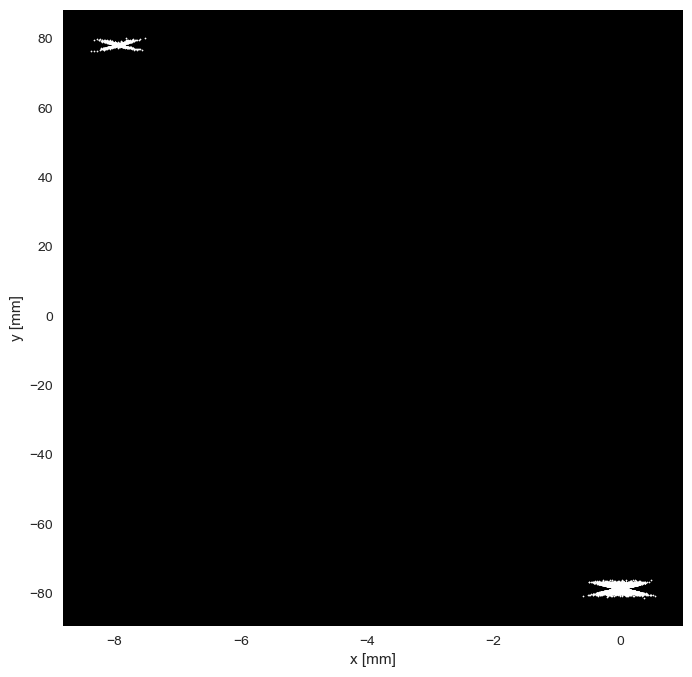

In [55]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", s=0.8)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    #ax1.set_title("Rays @ Grating LSF Best Focus [Z=" + str(round(grat_focus, 2)) + " mm]")
    #ax1.grid()

In [56]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.00152412, -0.02512973,  0.01086381, ...,  0.1068397 ,
         0.02952054,  0.00022239]),
 array([-78.52124456, -78.45699988, -78.47771019, ..., -77.47309451,
        -78.67343006, -79.04794859]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.00121869,  0.00550762, -0.00398927, ..., -0.00411534,
         0.01007425,  0.00034363]),
 array([-0.01974462, -0.01909349, -0.01945583, ..., -0.03417054,
        -0.03340458, -0.03495844]),
 array([0.99980431, 0.99980253, 0.99980276, ..., 0.99940754, 0.99939114,
        0.99938871]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [57]:
## # effeciency table as function of wavelength for look up  